# Extract a DEM from the planetary computer database

Planetary computer contains a catalog including dozens of different global datasets, which are easy and free to access:

https://planetarycomputer.microsoft.com/catalog


They are stored in a STAC (SpatioTemporal Asset Catalog), which is a structure to store geospatial data.


### Which Python packages do you need to install?

You'll need to install the following packages to interact with Planetary Computer's STAC:

- matplotlib (if you want to plot it)
- pystac-client
- stackstac
- dask
- xarray

All of them can be installed with pip or conda

In [1]:
import stackstac
import dask.diagnostics
import xarray as xr
import pystac_client

# Planetary computer's STAC URL
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

#### When querying data, remember that the input geometry needs to be given as longitudes and latitudes

In [2]:
# Point data
lon, lat = 12.50 , 55.70
mygeom = dict(type = "Point", coordinates = [lon, lat])

# Polygon 
#maxlon, maxlat, minlon, minlat = 10.0, 57.0, 12.5, 55.5
#mygeom = dict(type = "Polygon", coordinates = [[[minlon, minlat], [minlon, maxlat], [maxlon, maxlat], [maxlon, minlat], [minlon, minlat]]])


items = catalog.search(
    intersects=mygeom,
    collections=["cop-dem-glo-30"]
    ).item_collection()


In [3]:
# Access the catalog
stack = stackstac.stack(items)
stack

c:\Users\paco\AppData\Local\mambaforge\envs\stac_env\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-20e277f01e5aeb61fe9c57b6002084ab' (time: 1,
                                                                band: 1,
                                                                y: 3601, x: 2401)>
dask.array<fetch_raster_window, shape=(1, 1, 3601, 2401), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-04-22
    id              (time) <U40 'Copernicus_DSM_COG_10_N55_00_E012_00_DEM'
  * band            (band) <U4 'data'
  * x               (x) float64 12.0 12.0 12.0 12.0 12.0 ... 13.0 13.0 13.0 13.0
  * y               (y) float64 56.0 56.0 56.0 56.0 56.0 ... 55.0 55.0 55.0 55.0
    proj:epsg       int32 4326
    proj:shape      object {3600, 2400}
    platform        <U8 'TanDEM-X'
    proj:transform  object {0.0, -0.0002777777777777778, 0.000416666666666666...
    gsd             int32 30
    title           <U14 'N55_00_E012_00'
    epsg            int32 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(11.999583333333332, 55.0, 1...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 12.00|\n| 0.00,-0.00, 56.00|\n| 0.00, 0.00,...
    resolution_xy:  (0.00041666666666666664, 0.0002777777777777778)

In [4]:
# Download the data locally
with dask.diagnostics.ProgressBar():
    cop_dem = stack.compute()


[########################################] | 100% Completed | 1.84 ss


In [5]:
# If needed, stitch the DEM together
if cop_dem.time.shape[0] > 1:
    cop_dem = cop_dem.groupby('time').median()

# Select only the relevant dimensions
cop_dem = cop_dem.sel(time = cop_dem.time[0], band = 'data')

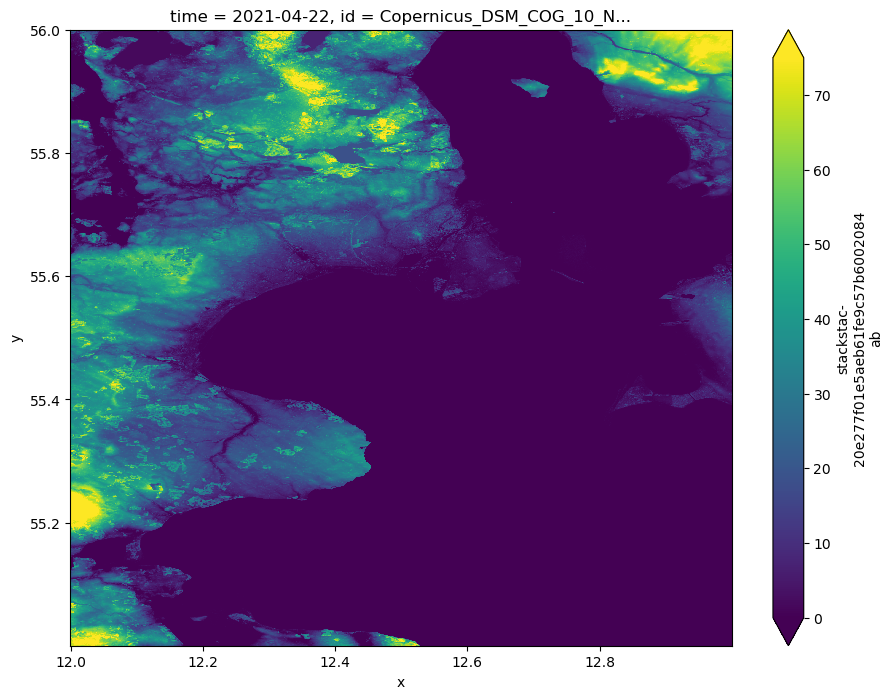

In [6]:
# Here is what it looks like!
cop_dem.plot.imshow(vmin = 0, vmax = 75, size = 8)

## Add-up : load an area from a shapefile and clip it to the specific area

Requires the following additional python packages:
- geopandas
- rioxarray

In [7]:
import geopandas as gpd
import rioxarray

# We make sure that the shapefile is in the right projection
gdf = gpd.read_file('Copenhagen.shp').to_crs('epsg:4326')

# The geometry from the shape file
shape_geom = gdf.loc[[0],'geometry']

In [8]:
items = catalog.search(
    intersects=shape_geom.loc[0],
    collections=["cop-dem-glo-30"]
    ).item_collection()


# Access the catalog
stack = stackstac.stack(items)

# Clip the data to the input shape
stack = stack.rio.clip(shape_geom.to_crs(stack.crs))

# And query the data
with dask.diagnostics.ProgressBar():
    copenhagen_dem = stack.compute()

if copenhagen_dem.time.shape[0] > 1:
    copenhagen_dem = copenhagen_dem.groupby('time').median()


copenhagen_dem = copenhagen_dem.sel(time = copenhagen_dem.time[0], band = 'data')

[                                        ] | 0% Completed | 726.40 us

c:\Users\paco\AppData\Local\mambaforge\envs\stac_env\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


[########################################] | 100% Completed | 681.73 ms


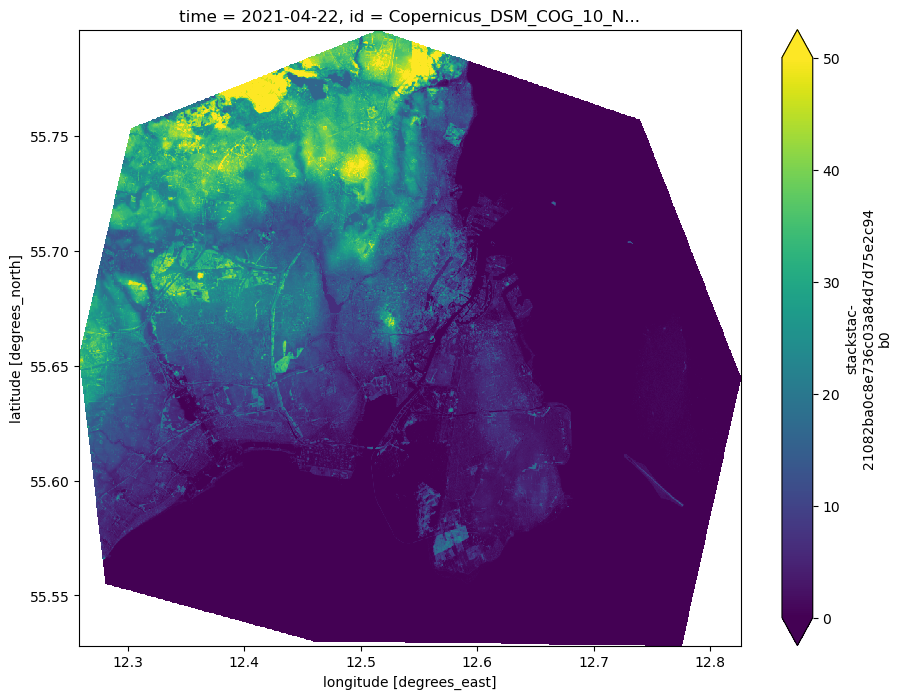

In [9]:
copenhagen_dem.plot.imshow(vmin = 0, vmax = 50, size = 8)

#### Save the data as a tif

For this you only need the rasterio package, which is installed together with the requirements from the previous packages

### If the dem was *not* clipped

In [10]:
import rasterio

output_name = 'Sjaelland_DEM.tif'

with rasterio.open(output_name, 'w', driver = 'GTiff', count = 1, 
                    height = cop_dem.shape[0], width  = cop_dem.shape[1],
                    dtype  = cop_dem.dtype,  crs = cop_dem.crs,  transform = cop_dem.transform) as output:
    output.write(cop_dem.values, 1)


### If it was clipped

In [20]:
import rasterio

output_name = 'Copenhagen_DEM.tif'

out_crs = 'epsg:'+str(copenhagen_dem.spec.epsg)

out_transform = rasterio.Affine(copenhagen_dem.resolution_xy[0], 0, copenhagen_dem.x.values[0], 
                                 0, -copenhagen_dem.resolution_xy[1], copenhagen_dem.y.values[0])

with rasterio.open(output_name, 'w', driver = 'GTiff', count = 1, 
                    height = copenhagen_dem.shape[0], width  = copenhagen_dem.shape[1],
                    dtype  = copenhagen_dem.dtype,  crs = out_crs,  transform = out_transform) as output:
    output.write(copenhagen_dem.values, 1)
